<a href="https://colab.research.google.com/github/rs-delve/tti-explorer/blob/master/notebooks/tti-experiment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## TTI Strategies

All of the information about the primary case's infection and how they infect their social contacts (under no government intervention) is now contained in `primary_case` and `social_contacts`.

Now we run a simulation, which works as follows. We start by generating a large number of cases, each with associated contacts. Given a particular strategy (e.g. test-based TTI with NPI of stringency level S3), each case is passed through the strategy, which computes various metrics for the case. For example, it computes the number of secondary cases due to primary case (reproduction number) and the number of tests required. We then collect the results for each case and average them, returning the final evaluation of the strategy.

## Running a Simulation

In [1]:
!git clone https://github.com/rs-delve/tti-explorer.git
%cd tti-explorer
%pip install -q .

import os

import numpy as np
import pandas as pd
from tqdm.notebook import trange

from tti_explorer import config, utils
from tti_explorer.case import simulate_case, CaseFactors
from tti_explorer.contacts import EmpiricalContactsSimulator
from tti_explorer.strategies import TTIFlowModel, RETURN_KEYS

%pip install pyDOE
%pip install emukit
%pip install gpy
import urllib.request
import numpy as np
import matplotlib.pyplot as plt

urllib.request.urlretrieve('https://raw.githubusercontent.com/lawrennd/talks/gh-pages/teaching_plots.py','teaching_plots.py')
urllib.request.urlretrieve('https://raw.githubusercontent.com/lawrennd/talks/gh-pages/mlai.py','mlai.py')
urllib.request.urlretrieve('https://raw.githubusercontent.com/lawrennd/talks/gh-pages/gp_tutorial.py','gp_tutorial.py')


from matplotlib import colors as mcolors
from matplotlib import cm
import numpy as np
import GPy
from emukit.core import ContinuousParameter, ParameterSpace
from emukit.sensitivity.monte_carlo import ModelFreeMonteCarloSensitivity
from emukit.core.initial_designs import RandomDesign
from GPy.models import GPRegression
from emukit.model_wrappers import GPyModelWrapper
from emukit.sensitivity.monte_carlo import MonteCarloSensitivity
from emukit.experimental_design.acquisitions import IntegratedVarianceReduction, ModelVariance
from emukit.experimental_design.experimental_design_loop import ExperimentalDesignLoop
import matplotlib.pyplot as pltb
import teaching_plots as plot
import mlai
import pandas as pd

fatal: destination path 'tti-explorer' already exists and is not an empty directory.
/Users/milliemcquillin/Desktop/MPhil/ML & PW/project/tti-le48/tti-explorer-with-changes/notebooks/millie/tti-explorer
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


We will analyse the `S3_test_based_TTI` strategy from our report. For clarity, we will show the whole process.

In [2]:
def load_csv(pth):
    return np.loadtxt(pth, dtype=int, skiprows=1, delimiter=",")

path_to_bbc_data = os.path.join("data", "bbc-pandemic")

over18 = load_csv(os.path.join(path_to_bbc_data, "contact_distributions_o18.csv"))
under18 = load_csv(os.path.join(path_to_bbc_data, "contact_distributions_u18.csv"))

First get the configurations:

In [3]:
name = 'S3_test_based_TTI'

case_config = config.get_case_config("delve")
contacts_config = config.get_contacts_config("delve")
policy_config = config.get_strategy_configs("delve", name)[name]

In [4]:
from scipy.stats import gamma

def update_case_config_day_noticed(p_day_noticed_symptoms_ab):
    alpha = p_day_noticed_symptoms_ab[0]
    beta = p_day_noticed_symptoms_ab[1]

    x = np.linspace(gamma.pdf(0.01, a=alpha, scale=1/beta),
                    gamma.pdf(0.99, a=alpha, scale=1/beta), 10)
    
    #apply softmax
    norm = np.exp(x)
    s = sum(norm)
    norm = np.round(norm/s, decimals=2)
    norm[-1] = 1- sum(norm[:-1])
    
    case_config['p_day_noticed_symptoms'] = norm
    
    return case_config



def update_case_config_daily(vals):
    
    case_config['inf_profile'] = vals
    
    return case_config




def update_case_inf_profile(inf_profile):
    alpha = inf_profile[0]
    beta = inf_profile[1]

    x = np.linspace(gamma.pdf(0.01, a=alpha, scale=1/beta),
                    gamma.pdf(0.99, a=alpha, scale=1/beta), 10)
    
    #apply softmax
    norm = np.exp(x)
    s = sum(norm)
    norm = np.round(norm/s, decimals=2)
    norm[-1] = 1- sum(norm[:-1])
    
    case_config['p_day_noticed_symptoms'] = norm
    
    return case_config

# update_case_config([1,3])

In [5]:
def update_policy_config(app_uptake, pol_compl):
    policy_config['app_cov'] = app_uptake
    policy_config['compliance'] = pol_compl
    return policy_config

# policy_config = update_policy_config(0.5, 0.05)

In [6]:
# Separating this because it is built from the ammended policy_config

factor_config = utils.get_sub_dictionary(policy_config, config.DELVE_CASE_FACTOR_KEYS)
strategy_config = utils.get_sub_dictionary(policy_config, config.DELVE_STRATEGY_FACTOR_KEYS)

Set a random state:

In [7]:
rng = np.random.RandomState(42)

Make contact simulator:

In [8]:
simulate_contacts = EmpiricalContactsSimulator(over18, under18, rng)

Make the TTI Model:

In [9]:
tti_model = TTIFlowModel(rng, **strategy_config)

Generate cases, contacts and run simulation:

In [10]:
"""
Runs TTI simulator as many times as the different input initialisations.
The main reason we need this is to put in to EmuKit for the Experimental
Design Loop.

Args:
    pol_configs (list): Inputs are [app_cov, compliance]

Returns:
    effective_rs (np.expand_dims(np.array(to_return), 1)): For every simulation run, return
    the effective r, as was plotted form Bryn and Andrei previously.

"""
rng = np.random.RandomState(42)
simulate_contacts = EmpiricalContactsSimulator(over18, under18, rng)

def run_tti_sim(pol_configs):
    
    to_return=[]

    for vals in pol_configs:

        case_config = update_case_config_daily(vals)
        #policy_config = update_policy_config(vals[0],vals[1])
        factor_config = utils.get_sub_dictionary(policy_config, config.DELVE_CASE_FACTOR_KEYS)
        strategy_config = utils.get_sub_dictionary(policy_config, config.DELVE_STRATEGY_FACTOR_KEYS)
        tti_model = TTIFlowModel(rng, **strategy_config)
        
        n_cases = 10000
        outputs = list()
        temp =[]
        
        for _ in trange(n_cases):
            case = simulate_case(rng, **case_config)
            
            case_factors = CaseFactors.simulate_from(rng, case, **factor_config)
            contacts = simulate_contacts(case, **contacts_config)
            res = tti_model(case, contacts, case_factors)
            outputs.append(res)
            
            if res["Effective R"] >= 0:
                temp.append(res["Effective R"]) # Get effective R. Only non-nan vals are kept
                
        to_return.append(np.mean(temp))
        
    return np.expand_dims(np.array(to_return), 1)




In [11]:
variable_domain = [0.05, 1] 
variable_domain2 = [0.01,1]

# space = ParameterSpace([ContinuousParameter('alpha', *variable_domain2),
#                         ContinuousParameter('beta', *variable_domain2)]) # init param space for experimental design

space = ParameterSpace([ContinuousParameter('Day_1', *variable_domain2),
                        ContinuousParameter('Day_2', *variable_domain2),
                        ContinuousParameter('Day_3', *variable_domain2),
                        ContinuousParameter('Day_4', *variable_domain2),
                        ContinuousParameter('Day_5', *variable_domain2),
                        ContinuousParameter('Day_6', *variable_domain2),
                        ContinuousParameter('Day_7', *variable_domain2),
                        ContinuousParameter('Day_8', *variable_domain2),
                        ContinuousParameter('Day_9', *variable_domain2),
                        ContinuousParameter('Day_10', *variable_domain2)]) 

In [12]:
# Set variables range. Since we are dealing with percentages (app_cov, compliance)
# [0.05, 1] should do.
initial_samples = 20 # number of random runs to perform before starting experimental design 

design = RandomDesign(space)

x = design.get_samples(initial_samples) # get 5 random combinations of initialisations
print(x)

for i, values in enumerate(x):
    x[i] = list(values/values.sum())

y = run_tti_sim(x) # obtain corresponding effective_rs

[[0.46243333 0.86750741 0.65346697 0.10171396 0.25956629 0.10049564
  0.11414997 0.52398042 0.51036222 0.3594597 ]
 [0.10798412 0.93568451 0.76225464 0.40964096 0.01481444 0.90857831
  0.57823106 0.78128946 0.92320009 0.48319236]
 [0.07238618 0.52130198 0.30367855 0.31062709 0.77921597 0.94149982
  0.70406302 0.53603004 0.41651127 0.77998812]
 [0.07698574 0.79038286 0.73815259 0.31007673 0.2982028  0.53899632
  0.57077496 0.56150668 0.33793579 0.98259558]
 [0.59862005 0.42310772 0.99841369 0.56908791 0.49340244 0.30780094
  0.28467862 0.51721607 0.37263853 0.77488381]
 [0.53684783 0.34529806 0.0234322  0.02136884 0.53427507 0.51005969
  0.427093   0.48249601 0.22559211 0.95518254]
 [0.07610121 0.79206773 0.57116993 0.80492821 0.23815576 0.33491096
  0.17664108 0.70998265 0.13182477 0.27386196]
 [0.36309059 0.91682156 0.88930423 0.56866592 0.86910072 0.67656354
  0.60298879 0.51629526 0.510996   0.65736076]
 [0.59535453 0.70988881 0.58591481 0.98965804 0.28027138 0.75222279
  0.59948748

In [13]:
# Fitting emulator to data, x: (app_cov, compliance), y: effective_r
Num_of_param = 10
kern_eq = GPy.kern.RBF(input_dim=Num_of_param, ARD = True)
kern_bias = GPy.kern.Bias(input_dim=Num_of_param)
kern = kern_eq + kern_bias
model_gpy = GPRegression(x,y, kern)
model_gpy.kern.variance = 1**2
model_gpy.likelihood.variance.fix(1e-5)
model_emukit = GPyModelWrapper(model_gpy) 
model_emukit.optimize() # optimise (max log-lik)
display(model_gpy)



Optimization restart 1/1, f = -25.688105027021113


GP_regression.,value,constraints,priors
sum.rbf.variance,0.5892734570461977,+ve,
sum.rbf.lengthscale,"(10,)",+ve,
sum.bias.variance,5.562684646268137e-309,+ve,
Gaussian_noise.variance,1e-05,+ve fixed,


In [14]:
# Initialise experimental design loop. Using integrated variance as acquisition
# to "query" the input space aiming to reduce uncertainty over the func we're approx. i.e. effective_r
num_of_loops = 50
integrated_variance = IntegratedVarianceReduction(space=space, model=model_emukit)
ed = ExperimentalDesignLoop(space=space, model=model_emukit, acquisition = integrated_variance)
ed.run_loop(run_tti_sim, num_of_loops)

Optimization restart 1/1, f = -25.68810503960519


 /Users/milliemcquillin/opt/anaconda3/envs/ml-pw-init/lib/python3.6/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1



Optimization restart 1/1, f = -13.911360201524863



Optimization restart 1/1, f = -11.999469347945277



Optimization restart 1/1, f = -10.675629261736873



Optimization restart 1/1, f = -6.920311095458185



Optimization restart 1/1, f = -5.331656159651306



Optimization restart 1/1, f = -3.3801777006694884



Optimization restart 1/1, f = 0.3005126219380294



Optimization restart 1/1, f = 2.66475377573099



Optimization restart 1/1, f = 3.237062442816482



Optimization restart 1/1, f = 14.25390669168077



Optimization restart 1/1, f = 18.745157803284656



Optimization restart 1/1, f = 23.894119632221237



Optimization restart 1/1, f = 32.66453468773875



Optimization restart 1/1, f = 35.7564864684856



Optimization restart 1/1, f = 38.83415055936294



Optimization restart 1/1, f = 41.89740741738693



Optimization restart 1/1, f = 45.243913485031584



Optimization restart 1/1, f = 48.881345830084086



Optimization restart 1/1, f = 51.3632618646761



Optimization restart 1/1, f = 54.39267418561691



Optimization restart 1/1, f = 56.430187113596446



Optimization restart 1/1, f = 58.48305511520639



Optimization restart 1/1, f = 60.55319663426226



Optimization restart 1/1, f = 61.67060276612328



Optimization restart 1/1, f = 63.74841006847895



Optimization restart 1/1, f = 68.5774885684976



Optimization restart 1/1, f = 70.57388511791711



Optimization restart 1/1, f = 74.16572854773526



Optimization restart 1/1, f = 76.85677106218



Optimization restart 1/1, f = 79.16813529463016



Optimization restart 1/1, f = 82.55250070078688



Optimization restart 1/1, f = 85.8608585521948



Optimization restart 1/1, f = 88.10247183845816



Optimization restart 1/1, f = 90.11165833796558



Optimization restart 1/1, f = 91.3587031476169



Optimization restart 1/1, f = 96.33857221087072



Optimization restart 1/1, f = 98.53443647323085



Optimization restart 1/1, f = 100.30758355576623



Optimization restart 1/1, f = 101.75848145412854



Optimization restart 1/1, f = 104.335703809716



Optimization restart 1/1, f = 106.29007439600504



Optimization restart 1/1, f = 112.79102621113343



Optimization restart 1/1, f = 117.96077166116683



Optimization restart 1/1, f = 120.64701889564957



Optimization restart 1/1, f = 122.87175256521483



Optimization restart 1/1, f = 124.83631586695485



Optimization restart 1/1, f = 127.57714109940032



Optimization restart 1/1, f = 130.97885795930299



Optimization restart 1/1, f = 132.65146818765353



Optimization restart 1/1, f = 134.53982891770005


main_effects:  {'Day_1': array([-0.05714221]), 'Day_2': array([-0.05805541]), 'Day_3': array([-0.05714221]), 'Day_4': array([-0.05714221]), 'Day_5': array([-0.05714219]), 'Day_6': array([-0.05630853]), 'Day_7': array([-0.05714221]), 'Day_8': array([0.17579553]), 'Day_9': array([-0.05658381]), 'Day_10': array([0.02921654])}
total_effects:  {'Day_1': array([0.14889875]), 'Day_2': array([0.14994693]), 'Day_3': array([0.14889875]), 'Day_4': array([0.14889875]), 'Day_5': array([0.14889875]), 'Day_6': array([0.14926013]), 'Day_7': array([0.14889875]), 'Day_8': array([1.03843183]), 'Day_9': array([0.14861553]), 'Day_10': array([0.87052131])}


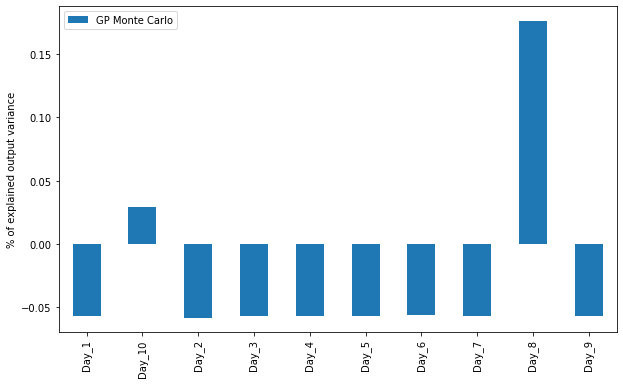

In [15]:
# Plot Main Effects

num_mc = 10000
senstivity = MonteCarloSensitivity(model = model_emukit, input_domain = space)
main_effects_gp, total_effects_gp, _ = senstivity.compute_effects(num_monte_carlo_points = num_mc)
print("main_effects: ", main_effects_gp)
print("total_effects: ", total_effects_gp)


fig, ax = plt.subplots(figsize=plot.big_wide_figsize)
main_effects_gp_plot = {ivar: main_effects_gp[ivar][0] for ivar in main_effects_gp}

d = {'GP Monte Carlo':main_effects_gp_plot}

pd.DataFrame(d).plot(kind='bar', ax=ax)
plt.ylabel('% of explained output variance')

mlai.write_figure(filename='first-order-sobol-indices-gp-catapult.svg', directory='./uq')

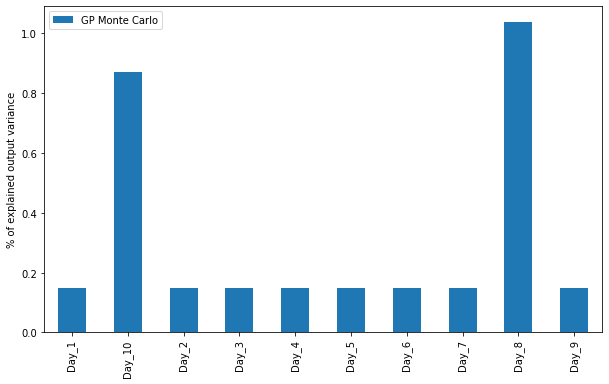

In [16]:
# Plot Total Effects

fig, ax = plt.subplots(figsize=plot.big_wide_figsize)

total_effects_gp_plot = {ivar: total_effects_gp[ivar][0] for ivar in total_effects_gp}

d = {'GP Monte Carlo':total_effects_gp_plot}

pd.DataFrame(d).plot(kind='bar', ax=ax)
ax.set_ylabel('% of explained output variance')

mlai.write_figure(filename='total-effects-sobol-indices-gp-catapult.svg', directory='./uq')